<a href="https://colab.research.google.com/github/mihnguyen/udemy-customer-analytics/blob/main/customer-segmentation/notebook_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Import Libraries

This notebook follows along [Udemy's Customer Analytics in Python 2020 course, Customer Segmentation section](https://www.udemy.com/course/customer-analytics-in-python/learn/lecture/16844950#content). Some self-exploration and modifications were added here and there.

In [1]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler # For standardizing data to the same scale

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

###Import Data

In [2]:
from google.colab import files
uploaded = files.upload()

Saving segmentation data.csv to segmentation data.csv


In [3]:
import io

df_segmentation = pd.read_csv(io.BytesIO(uploaded['segmentation data.csv']), index_col = 0)  # Making ID column an index column

###Explore Data

In [ ]:
df_segmentation.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [ ]:
df_segmentation.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


Note: Sex, Marital status, Education, Occupation, Settlement size fields (categorical fields) are assigned with arbitrary numerical values by the dataset creator, as opposed to numerical data that indicate magnitude (like Age, Income).

###Check Correlation

In [ ]:
df_segmentation.corr()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Sex,1.000000,0.566511,-0.182885,0.244838,-0.195146,-0.202491,-0.300803
Marital status,0.566511,1.000000,-0.213178,0.374017,-0.073528,-0.029490,-0.097041
Age,-0.182885,-0.213178,1.000000,0.654605,0.340610,0.108388,0.119751
Education,0.244838,0.374017,0.654605,1.000000,0.233459,0.064524,0.034732
Income,-0.195146,-0.073528,0.340610,0.233459,1.000000,0.680357,0.490881
Occupation,-0.202491,-0.029490,0.108388,0.064524,0.680357,1.000000,0.571795
Settlement size,-0.300803,-0.097041,0.119751,0.034732,0.490881,0.571795,1.000000


There seems to be a reasonably high correlation between Age - Education (correlation coefficient = 0.65), and between Occupation - Income (correlation coefficient = 0.68). That makes sense.

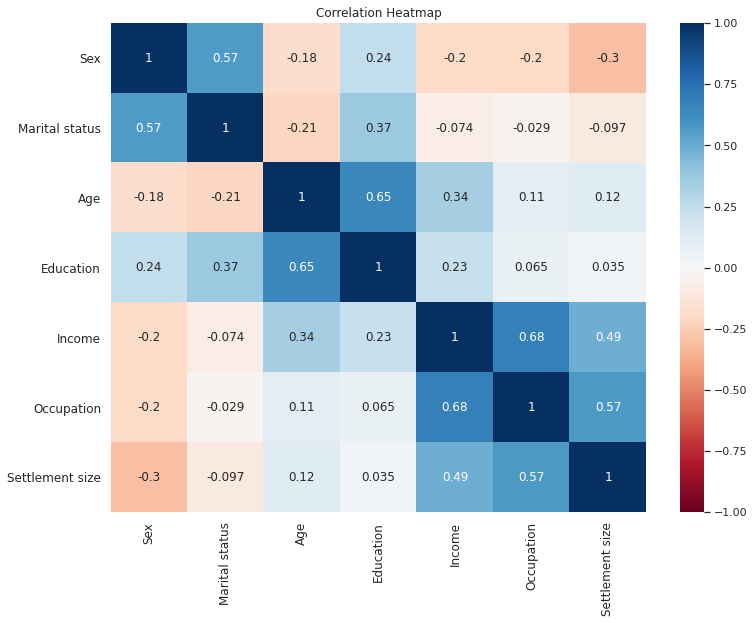

In [52]:
plt.figure(figsize = (12,9))
s = sns.heatmap(df_segmentation.corr(),
                annot = True,
                cmap = 'RdBu',
                vmin = -1,
                vmax = 1
                )
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

The correlation heatmap above is quite confusing for the eye to follow, so I looked up [this trick below (from Towards Data Science, "Better Heatmaps and Correlation Matrix Plots in Python" by Drazen Zaric
)](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec) that tweaks and turns scatterplot into representation of **size** and color scales. I made some modifications to the code.

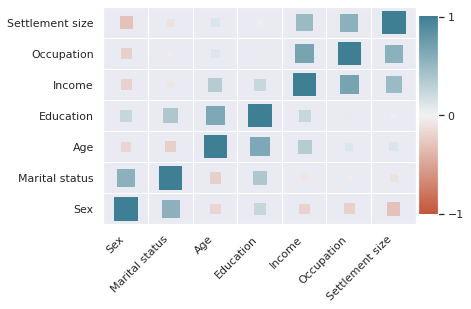

In [5]:
n_colors = 256 # Use 256 colors for the diverging color palette
palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation


# Add colors
def value_to_color(val):
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]

# Make a scatter plot with square markers, set column names as labels
def heatmap(x, y, size, color):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = x.unique()
    y_labels = y.unique()
    x_to_num = {labels:number for number, labels in enumerate(x_labels)} 
    y_to_num = {labels:number for number, labels in enumerate(y_labels)} 

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x15 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the leftmost 14 columns of the grid for the main plot

    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        c=color.apply(value_to_color), 
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    # Control the visualization
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5]) 
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])

    # Add color legend on the right side of the plot
    ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

    col_x = [0]*len(palette) # Fixed x coordinate for the bars
    bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

    bar_height = bar_y[1] - bar_y[0]
    ax.barh(
        y=bar_y,
        width=[5]*len(palette), # Make bars 5 units wide
        left=col_x, # Make bars start at 0
        height=bar_height,
        color=palette,
        linewidth=0
    )
    ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
    ax.grid(False) # Hide grid
    ax.set_facecolor('white') # Make background white
    ax.set_xticks([]) # Remove horizontal ticks
    ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
    ax.yaxis.tick_right() # Show vertical ticks on the right 

    
corr = df_segmentation.corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color=corr['value']
)

###Visualize Raw Data

Now we're going to make a scatter plot. Remember that Age and Income are the only 2 numerical data in this data set. Thus, let's plot a scatter plot for Age vs. Income.

Text(0.5, 1.0, 'Age vs. Income Raw Data')

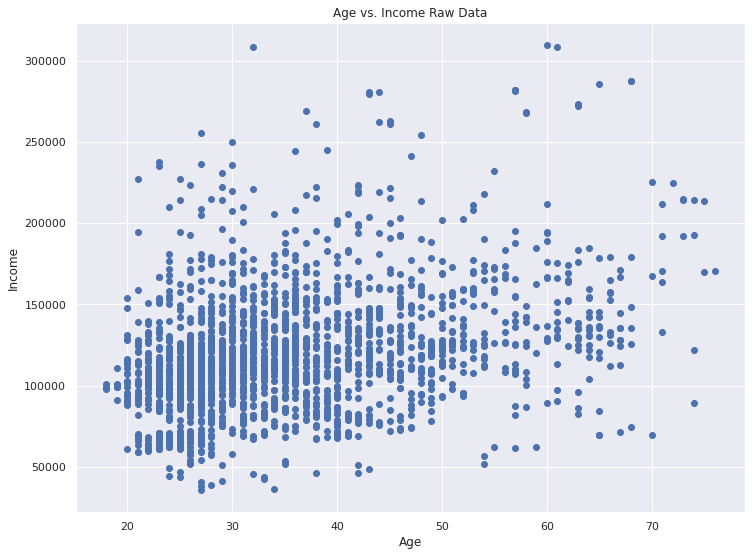

In [8]:
# Make scatterplot
plt.figure(figsize = (12,9))
plt.scatter(df_segmentation.iloc[:, 2], df_segmentation.iloc[:, 4])  # Remember that ID column has become an index column as mentioned before, so position 0 is now Sex
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Age vs. Income Raw Data')

According to the correlation check above, there's a very weak to no correlation between Age and Income (correlation = 0.34). The scatter plot confirms this as the data points are quite randomly distributed and spread out.

###Standardize Data

In [4]:
scaler = StandardScaler()
segmentation_standardized = scaler.fit_transform(df_segmentation)

###Apply Hierarchical Clustering

Apply Hierarchical Clustering using Ward method:

In [12]:
hier_clust = linkage(segmentation_standardized, method = 'ward')

Now use Dendrogram to visualize hierarchy tree and segments:

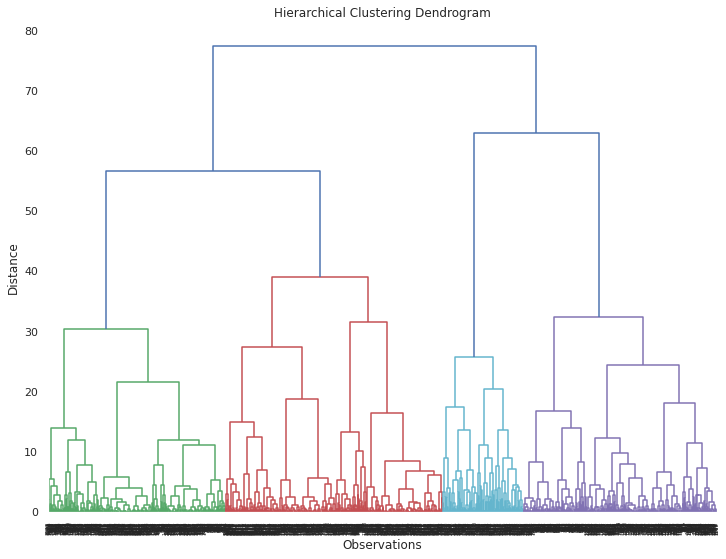

In [13]:
plt.figure(figsize = (12, 9))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
dendrogram(hier_clust, 
           show_leaf_counts = None,
           )
plt.show()

###Apply K-Means Clustering

First, let's determine the best number of clusters.

In [5]:
wcss = [] # Initialize
for i in range(1,11):
  kmeans = KMeans(n_clusters = i, 
                  init = 'k-means++',
                  random_state = 42)
  kmeans.fit(segmentation_standardized)
  wcss.append(kmeans.inertia_)

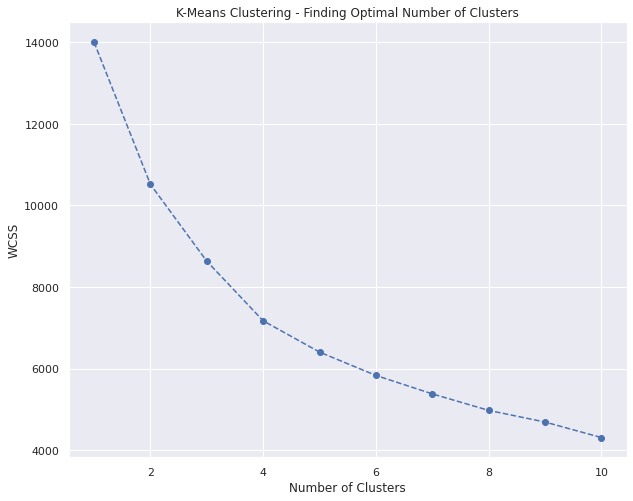

In [6]:
plt.figure(figsize = (10,8))
plt.plot(range(1,11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-Means Clustering - Finding Optimal Number of Clusters')
plt.show()

Using the Elbow method (find a point in the graph where the upper part is steep while the lower flatter), the number of clusters is 4.
Now is the time to perform K-Means:

In [7]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

In [8]:
kmeans.fit(segmentation_standardized)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

###Interpret Cluster Results

In [11]:
df_segment_kmeans = df_segmentation.copy() # Why make a copy of the segmentation data?
df_segment_kmeans['Segment K-Means'] = kmeans.labels_ # Add Segment K-Means column, which will contain each observation's predicted clusters, which can be extracted from labels_ attribute
df_segment_kmeans

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment K-Means
ID,,,,,,,,
100000001,0,0,67,2,124670,1,2,0
100000002,1,1,22,1,150773,1,2,3
100000003,0,0,49,1,89210,0,0,1
100000004,0,0,45,1,171565,1,1,2
100000005,0,0,53,1,149031,1,1,2
...,...,...,...,...,...,...,...,...
100001996,1,0,47,1,123525,0,0,1
100001997,1,1,27,1,117744,1,0,3
100001998,0,0,31,0,86400,0,0,1


Now let's check the characteristics of each segment. We can first check the mean of each segment, group by Segment K-Means column:

In [17]:
df_segment_analysis = df_segment_kmeans.groupby(['Segment K-Means']).mean()
df_segment_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segment K-Means,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290
2,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807
3,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695


Observations:
0. First segment (Well-Off): Equal men:women ratio. Over 2/3 have been married. Mean age above 50, also the oldest segment. Highest level of education, income, occupation.

1. Second segment (Fewer-Opportunnities): Mostly men. Almost none in a relationship. Mean age is 35, yet education, occupation, and income are among the lowest. Smallest settlement size, indicating most of this group live outside the city.

2. Third segment (Standard): Mostly women and married. Youngest, with medium level od education, income, occupation.

3. Fourth segment (Career-Focused): Mostly men. Mostly not in a relationship.Lowest level of education but second highest income, occupation. Largest settlement size.